In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import time
from itertools import product

In [2]:
url = 'https://npb.jp/bis/yearly/centralleague_1976.html'
lst = pd.read_html(url, header=0, flavor="lxml")
standings_df = lst[3]
batting_df = lst[4]
pitching_df = lst[5]

In [3]:
# 勝敗表（games / wins / losses / ties）
stand_cols = ["チーム", "試 合", "勝 利", "敗 北", "引 分"]
standings = (
    standings_df
    .loc[:, stand_cols]                       # 必要列だけ
    .rename(columns={                         # わかりやすい列名に統一
        "チーム": "チーム名",
        "試 合": "試合数",
        "勝 利": "勝数",
        "敗 北": "負数",
        "引 分": "引分数",
    })
)

# 打撃成績（runs scored = 得点）
bat_runs_col = [c for c in batting_df.columns if "得 点" in c][0]   # 年度によっては「得点」以外に表記ゆれがあるため
batting = (
    batting_df
    .loc[:, ["チーム", bat_runs_col]]
    .rename(columns={"チーム": "チーム名", bat_runs_col: "得 点"})
)

# 投手成績（runs allowed = 失点）
pit_runs_allowed_col = [c for c in pitching_df.columns if "失 点" in c][0]
pitching = (
    pitching_df
    .loc[:, ["チーム", pit_runs_allowed_col]]
    .rename(columns={"チーム": "チーム名", pit_runs_allowed_col: "失 点"})
)

# ─── 2) 左外部結合で順次マージ ───
team_summary_df = (
    standings
    .merge(batting,  how="left", on="チーム名")   # 得点を付加
    .merge(pitching, how="left", on="チーム名")   # 失点を付加
)

In [4]:
team_summary_df

,チーム名,試合数,勝数,負数,引分数,得 点,失 点
0,読売ジャイアンツ,130,76,45,9,661,505
1,阪神タイガース,130,72,45,13,602,500
2,広島東洋カープ,130,61,58,11,586,565
3,中日ドラゴンズ,130,54,66,10,519,610
4,ヤクルトスワローズ,130,52,68,10,504,555
5,大洋ホエールズ,130,45,78,7,482,619


In [28]:
# --------------------------
# 1. 収集対象の年度・リーグ
# --------------------------
years   = range(1950, 2025)                          # 1950-2024
leagues = {"centralleague": "セ", "pacificleague": "パ"}  # 表示用略称

# --------------------------
# 2. テーブル分類ヘルパ
# --------------------------
def classify_table(df: pd.DataFrame) -> str | None:
    cols = "".join(map(str, df.columns))
    if "打率" in cols:      # チーム打撃成績
        return "batting"
    if "防御率" in cols:    # チーム投手成績
        return "pitching"
    if ("勝" in cols) and ("敗" in cols) and ("率" not in cols):
        # 打率・防御率の入らない勝敗表
        return "standings"
    return None

# --------------------------
# 3. 列名取得ヘルパ
# --------------------------
def find_col(df: pd.DataFrame, pattern: str) -> str:
    """列名リストから正規表現にマッチする最初の列名を返す（無ければ KeyError）。"""
    for c in df.columns:
        if re.search(pattern, str(c)):
            return c
    raise KeyError(f"Column matching /{pattern}/ not found")

# --------------------------
# 4. １年度×１リーグ分の DataFrame を返す
# --------------------------
def scrape_one(year: int, league_key: str, league_label: str) -> pd.DataFrame:
    url = f"https://npb.jp/bis/yearly/{league_key}_{year}.html"
    try:
        tables = pd.read_html(url, header=0, flavor="lxml")
    except ValueError:
        # ページ無し（リーグ創設前など）→ 空 DataFrame
        return pd.DataFrame(columns=[
            "年度", "リーグ", "チーム名", "試合数",
            "勝数", "負数", "引分数", "得点", "失点"
        ])

    # --- 分類 ---
    tb = {"standings": None, "batting": None, "pitching": None}
    for df in tables:
        kind = classify_table(df)
        if kind and tb[kind] is None:
            tb[kind] = df.copy()

    # 勝敗表が見つからなければスキップ
    if tb["standings"] is None:
        return pd.DataFrame()

    # --- ① 勝敗表 ---
    s = tb["standings"].copy()
    print(s)
    s["チーム"] = s["チーム"].astype(str).str.strip()
    games_col  = find_col(s, "試合")
    win_col    = find_col(s, "^勝")
    loss_col   = find_col(s, "^敗")
    # 引分列は無い年度もある
    tie_col    = next((c for c in s.columns if re.match("^引|^分", str(c))), None)

    standings = (
        s.loc[:, ["チーム", games_col, win_col, loss_col] + ([tie_col] if tie_col else [])]
         .rename(columns={
             "チーム": "チーム名",
             games_col: "試合数",
             win_col:   "勝数",
             loss_col:  "負数",
         })
    )
    if tie_col is None:
        standings["引分数"] = 0
    else:
        standings = standings.rename(columns={tie_col: "引分数"})

    # --- ② 打撃（得点） ---
    if tb["batting"] is not None:
        b = tb["batting"].copy()
        b["チーム"] = b["チーム"].astype(str).str.strip()
        run_col = find_col(b, "得点")
        batting = (
            b.loc[:, ["チーム", run_col]]
             .rename(columns={"チーム": "チーム名", run_col: "得点"})
        )
    else:
        batting = pd.DataFrame(columns=["チーム名", "得点"])

    # --- ③ 投手（失点） ---
    if tb["pitching"] is not None:
        p = tb["pitching"].copy()
        p["チーム"] = p["チーム"].astype(str).str.strip()
        ra_col = find_col(p, "失点")
        pitching = (
            p.loc[:, ["チーム", ra_col]]
             .rename(columns={"チーム": "チーム名", ra_col: "失点"})
        )
    else:
        pitching = pd.DataFrame(columns=["チーム名", "失点"])

    # --- マージ ---
    year_df = (
        standings
        .merge(batting,  how="left", on="チーム名")
        .merge(pitching, how="left", on="チーム名")
    )

    # 打撃・投手表が空のときは NaN → 0 に
    year_df["得点"] = year_df["得点"].fillna(0).astype(int)
    year_df["失点"] = year_df["失点"].fillna(0).astype(int)

    # 年度・リーグ列を付加
    year_df.insert(0, "リーグ", league_label)
    year_df.insert(0, "年度", year)

    # リーグ平均などの行を除外
    year_df = year_df[~year_df["チーム名"].str.contains("平均")]

    return year_df

# --------------------------
# 5. 全年度・全リーグを収集
# --------------------------
dfs = []
for year, (league_key, league_label) in product(years, leagues.items()):
    time.sleep(1)
    print(year)
    df = scrape_one(year, league_key, league_label)
    if not df.empty:
        dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)

# --------------------------
# 6. 確認（例）
# --------------------------
print(all_df.head())
print(f"\n→ 合計 {len(all_df):,} 行")

1950
Empty DataFrame
Columns: [■ チーム勝敗表 ‐ チーム打撃成績 ‐ チーム投手成績 ‐ リーグ・リーダーズ ‐ 個人打撃成績 ‐ 個人投手成績 ■]
Index: []


KeyError: 'チーム'

In [5]:
def get_standings(url):
    lst = pd.read_html(url, header=0, flavor="lxml")
    standings_df = lst[3]
    batting_df = lst[4]
    pitching_df = lst[5]

    # 勝敗表（games / wins / losses / ties）
    stand_cols = ["チーム", "試 合", "勝 利", "敗 北", "引 分"]
    standings = (
        standings_df
        .loc[:, stand_cols]                       # 必要列だけ
        .rename(columns={                         # わかりやすい列名に統一
            "チーム": "チーム名",
            "試 合": "試合数",
            "勝 利": "勝数",
            "敗 北": "負数",
            "引 分": "引分数",
        })
    )

    # 打撃成績（runs scored = 得点）
    bat_runs_col = [c for c in batting_df.columns if "得 点" in c][0]   # 年度によっては「得点」以外に表記ゆれがあるため
    batting = (
        batting_df
        .loc[:, ["チーム", bat_runs_col]]
        .rename(columns={"チーム": "チーム名", bat_runs_col: "得 点"})
    )
    
    # 投手成績（runs allowed = 失点）
    pit_runs_allowed_col = [c for c in pitching_df.columns if "失 点" in c][0]
    pitching = (
        pitching_df
        .loc[:, ["チーム", pit_runs_allowed_col]]
        .rename(columns={"チーム": "チーム名", pit_runs_allowed_col: "失 点"})
    )
    
    # ─── 2) 左外部結合で順次マージ ───
    team_summary_df = (
        standings
        .merge(batting,  how="left", on="チーム名")   # 得点を付加
        .merge(pitching, how="left", on="チーム名")   # 失点を付加
    )
    return team_summary_df

In [6]:
url = 'https://npb.jp/bis/yearly/pacificleague_2024.html'
df = get_standings(url)
df

,チーム名,試合数,勝数,負数,引分数,得 点,失 点
0,福岡ソフトバンクホークス,143,91,49,3,607,390
1,北海道日本ハムファイターズ,143,75,60,8,532,485
2,千葉ロッテマリーンズ,143,71,66,6,493,495
3,東北楽天ゴールデンイーグルス,143,67,72,4,492,579
4,オリックス・バファローズ,143,63,77,3,402,448
5,埼玉西武ライオンズ,143,49,91,3,350,485


In [8]:
dfs = []
years   = range(1950, 2025)                          # 1950-2024
leagues = {"centralleague": "セ", "pacificleague": "パ"}  # 表示用略称
for year, (league_key, league_label) in product(years, leagues.items()):
    url = f"https://npb.jp/bis/yearly/{league_key}_{year}.html"
    print(url)
    df = get_standings(url)
    df['年度']=year
    df['リーグ']=league_key
    dfs.append(df)
    time.sleep(1)

all_df = pd.concat(dfs, ignore_index=True)

https://npb.jp/bis/yearly/centralleague_1950.html
https://npb.jp/bis/yearly/pacificleague_1950.html
https://npb.jp/bis/yearly/centralleague_1951.html
https://npb.jp/bis/yearly/pacificleague_1951.html
https://npb.jp/bis/yearly/centralleague_1952.html
https://npb.jp/bis/yearly/pacificleague_1952.html
https://npb.jp/bis/yearly/centralleague_1953.html
https://npb.jp/bis/yearly/pacificleague_1953.html
https://npb.jp/bis/yearly/centralleague_1954.html
https://npb.jp/bis/yearly/pacificleague_1954.html
https://npb.jp/bis/yearly/centralleague_1955.html
https://npb.jp/bis/yearly/pacificleague_1955.html
https://npb.jp/bis/yearly/centralleague_1956.html
https://npb.jp/bis/yearly/pacificleague_1956.html
https://npb.jp/bis/yearly/centralleague_1957.html
https://npb.jp/bis/yearly/pacificleague_1957.html
https://npb.jp/bis/yearly/centralleague_1958.html
https://npb.jp/bis/yearly/pacificleague_1958.html
https://npb.jp/bis/yearly/centralleague_1959.html
https://npb.jp/bis/yearly/pacificleague_1959.html


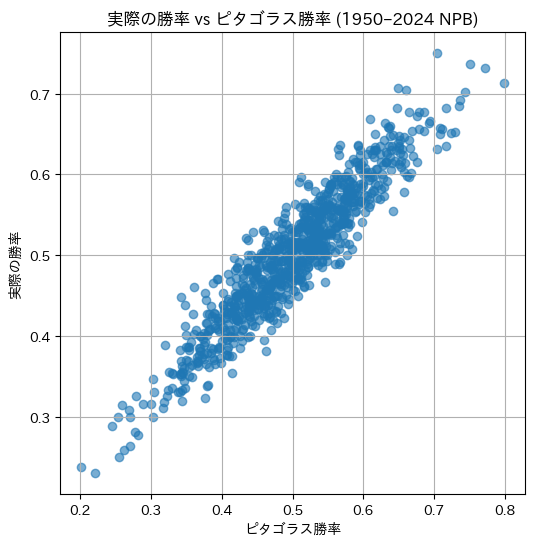

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from adjustText import adjust_text
# --- 1) 既存 all_df に列を追加 ----------------------------
# ピタゴラス勝率:  得点^2 / (得点^2 + 失点^2)
all_df["ピタゴラス勝率"] = (all_df["得 点"] ** 2) / ((all_df["得 点"] ** 2) + (all_df["失 点"] ** 2))

# 実際の勝率: (勝 + 0.5×引分) / 試合
all_df["実際の勝率"] = all_df["勝数"]  / (all_df["勝数"]+all_df["負数"] )

# --- 2) 二次元プロット -----------------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(all_df["ピタゴラス勝率"], all_df["実際の勝率"], alpha=0.6)
ax.set_xlabel("ピタゴラス勝率")
ax.set_ylabel("実際の勝率")
ax.set_title("実際の勝率 vs ピタゴラス勝率 (1950–2024 NPB)")
ax.grid(True)
plt.show()

In [12]:
label_df = all_df[(all_df['年度'] == 2017) & (all_df['チーム名'] == '東京ヤクルトスワローズ')]

In [17]:
label_df.loc[915] = ['東京ヤクルトスワローズ', 56, 17, 37, 2, 138, 233, 2025, "centralleague", 138**2/(138**2+233**2), 0.315]

/tmp/ipykernel_27808/3103135655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df.loc[915] = ['東京ヤクルトスワローズ', 56, 17, 37, 2, 138, 233, 2025, "centralleague", 138**2/(138**2+233**2), 0.315]


In [19]:
all_df.loc[915] = ['東京ヤクルトスワローズ', 56, 17, 37, 2, 138, 233, 2025, "centralleague", 138**2/(138**2+233**2), 0.315]

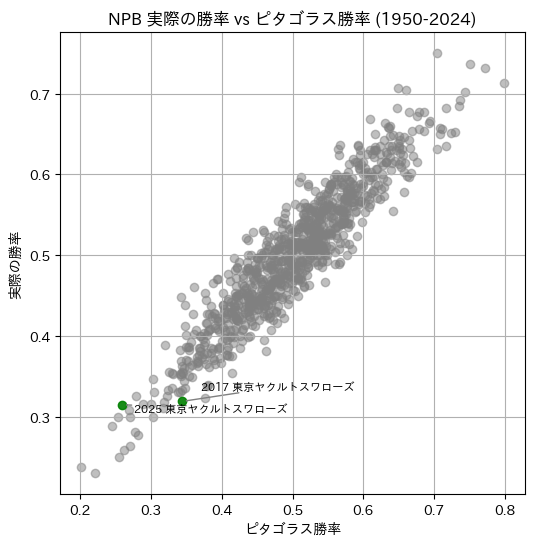

In [27]:
# --- 2) プロットとアノテーション ---------------------------
# ① ラベル対象マスク
mask = all_df.index.isin(label_df.index)


fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    all_df.loc[~mask, "ピタゴラス勝率"],
    all_df.loc[~mask, "実際の勝率"],
    alpha=0.5, color="gray", label="その他"
)
ax.scatter(
    all_df.loc[mask, "ピタゴラス勝率"],
    all_df.loc[mask, "実際の勝率"],
    alpha=0.9, color="green", label="ラベル対象"
)


texts = []
for _, row in label_df.iterrows():
    texts.append(
        ax.text(row["ピタゴラス勝率"], row["実際の勝率"],
                f"{row['年度']} {row['チーム名']}", fontsize=8)
    )

adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray"))

ax.set_xlabel("ピタゴラス勝率")
ax.set_ylabel("実際の勝率")
ax.set_title("NPB 実際の勝率 vs ピタゴラス勝率 (1950-2024)")
ax.grid(True)
plt.savefig('ptgall.png')
plt.show()